In [1]:
from matplotlib import pyplot as plt
import numpy as np
from time import time
from os.path import abspath, join, pardir
import sys 
from glob import glob 
import vaex
from hammer import Model
current = abspath("")
root_dir = abspath(join(current, pardir))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params, concat,
                   get_initial_position_normal, get_data, generate_init)

style()

In [3]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'n')
z_dir_path

'/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n'

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [5]:
rhob_mean = df_baryon['rho'].to_numpy()
rhob_err = df_baryon['e_rho'].to_numpy()
sigmaz_mean = df_baryon['sigma_z'].to_numpy()
sigmaz_err = df_baryon['e_sigma_z'].to_numpy()

In [6]:
vel_dir_path = join(root_data_dir, "MCMC-no", "mock", "result", "n", "vel", "data")
# vel_dir_path = join(root_data_dir, "MCMC-no", "vel", "data")
vel_files = glob(join(vel_dir_path, "*.npy"))
vel_files.sort()
vel_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_00500.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_01000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_01500.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_02000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_05000.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/n/vel/data/chain_10000.npy']

In [7]:
index = 5
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
z_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_00500.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_01000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_01500.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_02000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_05000.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/n/z_10000.hdf5']

In [8]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata = get_data(z_files[index])
vel = np.load(vel_files[index])
zdata, name, vel[:5]

((array([-381.78577856, -345.63218786, -309.47859716, -273.32500646,
         -237.17141576, -201.01782506, -164.86423436, -128.71064366,
          -92.55705297,  -56.40346227,  -20.24987157,   15.90371913,
           52.05730983,   88.21090053,  124.36449123,  160.51808193,
          196.67167263,  232.82526333,  268.97885403,  305.13244472,
          341.28603542,  377.43962612]),
  array([0.00626862, 0.00940292, 0.01932823, 0.03186547, 0.04596985,
         0.09298448, 0.1776108 , 0.36723644, 0.66081664, 0.95126254,
         0.97790416, 0.79297997, 0.53231001, 0.27268481, 0.12014848,
         0.07574578, 0.03447739, 0.02350731, 0.01514916, 0.00731339,
         0.00574623, 0.00313431]),
  array([0.00180959, 0.00221629, 0.00317754, 0.00407995, 0.0049004 ,
         0.00696948, 0.0096323 , 0.01385058, 0.01857957, 0.02229181,
         0.02260182, 0.0203529 , 0.01667545, 0.01193509, 0.00792236,
         0.00629034, 0.00424387, 0.00350426, 0.00281313, 0.00195458,
         0.00173255, 0.0012

In [9]:
vel.shape

(60000, 5)

# choosing $\psi_b$

In [10]:
psi = np.empty(30)

rhob = np.random.normal(rhob_mean, rhob_err, size=(1, 12))
sigmaz = np.random.normal(sigmaz_mean, sigmaz_err, size=(1, 12))
r = np.random.normal(3.4E-3, 0.6E-3, size=(1))
random_indices = np.random.choice(np.arange(len(psi)), size=1, replace=False)
w0 = vel[random_indices, 0]
log_sigmaw = vel[random_indices, 1]
q_sigmaw = vel[random_indices, 2]
log_a = vel[random_indices, 3]
q_a = vel[random_indices, 4]

# combine
psi[:12] = rhob
psi[12:24] = sigmaz
psi[24] = r
psi[25] = w0
psi[26] = log_sigmaw
psi[27] = q_sigmaw
psi[28] = log_a
psi[29] = q_a

psi.shape

(30,)

# run_mcmc

In [11]:
from typing import Tuple
from tqdm import tqdm
from time import time
from enum import Enum
from hammer import Model as MCMC_Model
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"
    KIN = "KIN"

func_dict = {
    "DM": MCMC_Model.DM,
    "DDDM": MCMC_Model.DDDM,
    "NO": MCMC_Model.NO,
}

def mcmc_z(model: Model, z_path: str, psi: np.ndarray, **options):
    """
    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    z_path: `str` = path to z file \n
    psi: `np.ndarray` = shape(4) \n

    options:
        step0: `int` = 500 \n
        step: `int` = 2000 \n
        burn: `int` = 1000 \n
        it: `int` = 3 \n
        thin: `int` = 20 \n
        verbose: `bool` = True \n
        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { \n
        indexes: `ndarray(shape(nparam))`, \n
        labs: `ndarray(shape(nparam))`, \n
        labels: `ndarray(shape(nparam))`, \n
        chain: `ndarray(shape(nstep,nwalker,nparam))` \n
    }
    """
    step0 = options.get("step0", 100)
    step = options.get("step", 2000)
    burn = options.get("burn", 1000)
    it = options.get("it", 3)
    thin = options.get("thin", 20)
    verbose = options.get("verbose", True)
    m = options.get("m", 10)
    func = func_dict[model.value]
    if verbose: print("running...")
    name = z_path.split("/")[-1].replace(".hdf5", "").replace("z_", "")
    zdata = get_data(z_path)
    
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']    
    indexes = init['indexes']
    labs = init['labs']
    labels = init['labels']

    ndim = len(locs)
    nwalker = m*ndim
    if verbose: print(f"mcmc... {name}")
    p0 = func.generate_p0(nwalker, locs, scales)
    for i in tqdm(range(it), desc="mcmc"):
        t0 = time()
        chain = func.mcmc(step0, p0, psi, zdata, locs, scales,  parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: first half mcmc done {np.round(t1-t0, 2)} s")
        locs_normal, scales_normal = get_initial_position_normal(model, chain=chain[int(step0/2):])
        p0 = func.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
        t0 = time()
        chain = func.mcmc(step0, p0, psi, zdata, locs, scales,  parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: second half mcmc done {np.round(t1-t0, 2)} s")
        p0 = chain[-1]
    t0 = time()
    chain = func.mcmc(burn, p0, psi, zdata, locs, scales,  parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"burn done {np.round(t1-t0, 2)} s")
    p0 = chain[-1]
    t0 = time()
    chain = func.mcmc(step, p0, psi, zdata, locs, scales,  parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"mcmc done {np.round(t1-t0, 2)} s")
    chain_thin = chain[::thin]
    return {
        "indexes": indexes,
        "labs": labs,
        "labels": labels,
        "chain": chain_thin
        }

In [12]:
result = mcmc_z(
    model=Model.DM,
    z_path=z_files[index],
    psi=psi,
    step0=100,
    step=100,
    burn=100,
    it=1,
    thin=1,
    m=10
)

result.keys()

running...
mcmc... 10000


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 0.34 s

mcmc: 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

0: second half mcmc done 0.29 s
burn done 0.27 s
mcmc done 0.28 s

dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [13]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
step, nwalker, ndim = chain_thin.shape
step, nwalker, ndim

(100, 30, 3)

100%|██████████| 3/3 [00:00<00:00, 72.86it/s]


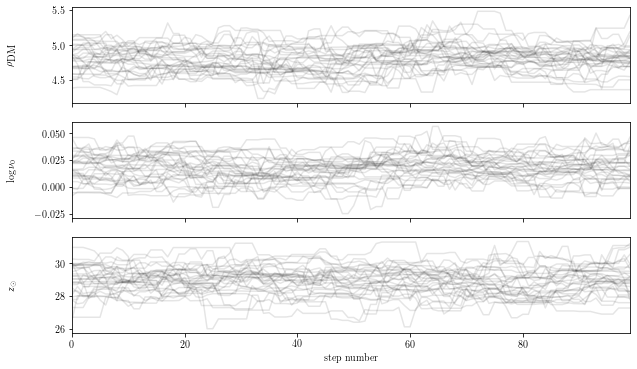

In [14]:
from utils import plot_chain, get_params

params = get_params(chain_thin, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.1,
    figsize=(10, 6),
)

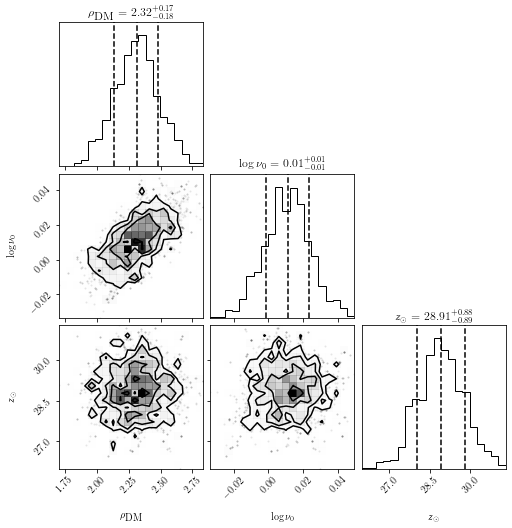

In [22]:
from utils import plot_corner

params = get_params(chain_thin, indexes, labs)

plot_corner(
    params=params,
    labels=labels,
)

# mcmc_parallel

In [10]:
nsample = 10 #len(vel)
psi = np.empty((nsample, 30))

rhob = np.random.normal(rhob_mean, rhob_err, size=(nsample, 12))
sigmaz = np.random.normal(sigmaz_mean, sigmaz_err, size=(nsample, 12))
r = np.random.normal(3.4E-3, 0.6E-3, size=(nsample))
random_indices = np.random.choice(np.arange(len(psi)), size=nsample, replace=False)
w0 = vel[random_indices, 0]
log_sigmaw = vel[random_indices, 1]
q_sigmaw = vel[random_indices, 2]
log_a = vel[random_indices, 3]
q_a = vel[random_indices, 4]

# combine
psi[:, :12] = rhob
psi[:, 12:24] = sigmaz
psi[:, 24] = r
psi[:, 25] = w0
psi[:, 26] = log_sigmaw
psi[:, 27] = q_sigmaw
psi[:, 28] = log_a
psi[:, 29] = q_a

psi.shape

(10, 30)

In [15]:
# from hammer import Model as Model_MCMC
# from utils import Model

# init = generate_init(Model.DM)
# locs = init['locs']
# scales = init['scales']    
# indexes = init['indexes']
# labs = init['labs']
# labels = init['labels']
# ndim = len(locs)
# nwalker = 10*ndim
# p0 = Model_MCMC.DM.generate_p0(nwalker, locs, scales)
# p0 = np.array([p0])
# Model_MCMC.DM.log_prob_par(p0, psi[:1], zdata, locs, scales, batch=10)

array([[[-4.90527478e+00, -1.83329567e+03, -1.83820094e+03],
        [-4.90527478e+00, -9.18183158e+02, -9.23088433e+02],
        [-4.90527478e+00, -2.03601164e+03, -2.04091692e+03],
        [-4.90527478e+00, -3.13090659e+03, -3.13581187e+03],
        [-4.90527478e+00, -9.33958566e+03, -9.34449094e+03],
        [-4.90527478e+00, -3.21157421e+03, -3.21647948e+03],
        [-4.90527478e+00, -5.04800259e+02, -5.09705534e+02],
        [-4.90527478e+00, -7.65488141e+03, -7.65978669e+03],
        [-4.90527478e+00, -6.40212418e+04, -6.40261471e+04],
        [-4.90527478e+00, -2.94380142e+04, -2.94429195e+04],
        [-4.90527478e+00, -8.52773802e+04, -8.52822854e+04],
        [-4.90527478e+00, -1.63237842e+03, -1.63728370e+03],
        [-4.90527478e+00, -4.15198416e+04, -4.15247469e+04],
        [-4.90527478e+00, -4.46155852e+03, -4.46646379e+03],
        [-4.90527478e+00, -2.38251248e+03, -2.38741776e+03],
        [-4.90527478e+00, -6.85116338e+03, -6.85606865e+03],
        [-4.90527478e+00

In [16]:
psi[:1].shape

(1, 30)

In [18]:
from typing import Tuple
from tqdm import tqdm
from time import time
from enum import Enum
from hammer import Model as Model_MCMC
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"
    KIN = "KIN"

func_dict = {
    "DM": Model_MCMC.DM,
    "DDDM": Model_MCMC.DDDM,
    "NO": Model_MCMC.NO,
}

def mcmc_parallel_z(model: Model, z_path: str, psi: np.ndarray, **options):
    """
    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    z_path: `str` = path to z file \n
    psi: `np.ndarray` = shape(nmcmc, 4) \n

    options:
        step0: `int` = 500 \n
        step: `int` = 2000 \n
        burn: `int` = 1000 \n
        it: `int` = 3 \n
        thin: `int` = 20 \n
        verbose: `bool` = True \n
        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { \n
        indexes: `ndarray(shape(nparam))`, \n
        labs: `ndarray(shape(nparam))`, \n
        labels: `ndarray(shape(nparam))`, \n
        chain: `ndarray(shape(nstep,nwalker,nparam))` \n
    }
    """
    step0 = options.get("step0", 100)
    step = options.get("step", 2000)
    burn = options.get("burn", 1000)
    it = options.get("it", 3)
    thin = options.get("thin", 20)
    verbose = options.get("verbose", True)
    m = options.get("m", 10)
    func = func_dict[model.value]
    if verbose: print("running...")
    name = z_path.split("/")[-1].replace(".hdf5", "").replace("z_", "")
    zdata = get_data(z_path)
    
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']    
    indexes = init['indexes']
    labs = init['labs']
    labels = init['labels']

    ndim = len(locs)
    nwalker = m*ndim
    n_mcmc = psi.shape[0]
    if verbose: print(f"mcmc... {name}")
    p0 = func.generate_p0(nwalker, locs, scales)
    p0 = np.tile(p0, (n_mcmc, 1, 1))
    print(p0.shape)
    for i in tqdm(range(it), desc="mcmc"):
        t0 = time()
        chain = func.mcmc_parallel(step0, p0, psi, zdata, locs, scales,  parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: first half mcmc done {np.round(t1-t0, 2)} s")
        for j in range(n_mcmc):
            locs_normal, scales_normal = get_initial_position_normal(model, chain=chain[j, int(step0/2):])
            p0_j = func.generate_p0(nwalker, locs_normal, scales_normal, norm=True)
            p0[j] = p0_j
        t0 = time()
        chain = func.mcmc_parallel(step0, p0, psi, zdata, locs, scales, parallel=True, verbose=verbose)
        t1 = time()
        if verbose: print(f"{i}: second half mcmc done {np.round(t1-t0, 2)} s")
        p0 = chain[:, -1]
    t0 = time()
    chain = func.mcmc_parallel(burn, p0, psi, zdata, locs, scales, parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"burn done {np.round(t1-t0, 2)} s")
    p0 = chain[:, -1]
    t0 = time()
    chain = func.mcmc_parallel(step, p0, psi, zdata, locs, scales, parallel=True, verbose=verbose)
    t1 = time()
    if verbose: print(f"mcmc done {np.round(t1-t0, 2)} s")
    chain_thin = chain[:, ::thin]
    return {
        "indexes": indexes,
        "labs": labs,
        "labels": labels,
        "chain": chain_thin
        }

In [19]:
psi.shape

(10, 30)

In [20]:
# mask = np.random.choice(np.arange(len(pot_b)), size=500, replace=False)

result = mcmc_parallel_z(
    model=Model.DM,
    z_path=z_files[index],
    psi=psi,
    step0=100,
    step=100,
    burn=100,
    it=1,
    thin=2,
    m=10
)
# result.shape
result.keys()

running...
mcmc... 10000
(10, 30, 3)


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 2.38 s


mcmc: 100%|██████████| 1/1 [00:04<00:00,  4.71s/it]

0: second half mcmc done 2.32 s
burn done 2.38 s
mcmc done 2.35 s

dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [21]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
n_mcmc, step, nwalker, ndim = chain_thin.shape
n_mcmc, step, nwalker, ndim

(10, 50, 30, 3)

# plot_chain

100%|██████████| 3/3 [00:00<00:00,  7.50it/s]

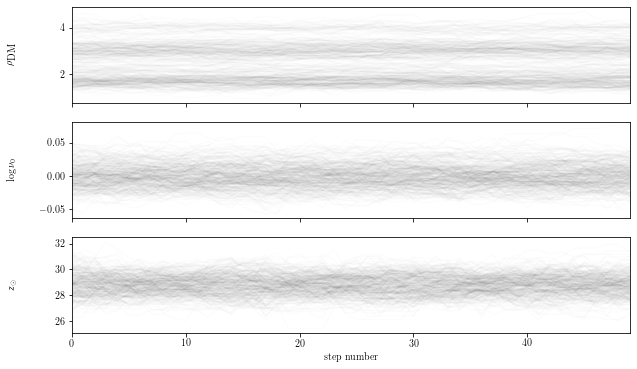

In [22]:
from utils import plot_chain, get_params

chain = np.transpose(chain_thin, (1, 0, 2, 3)).reshape((step, -1, ndim))
params = get_params(chain, indexes, labs)

plot_chain(
    params=params,
    labels=labels,
    alpha=0.01,
    figsize=(10, 6),
)

In [23]:
params.shape

(50, 300, 3)

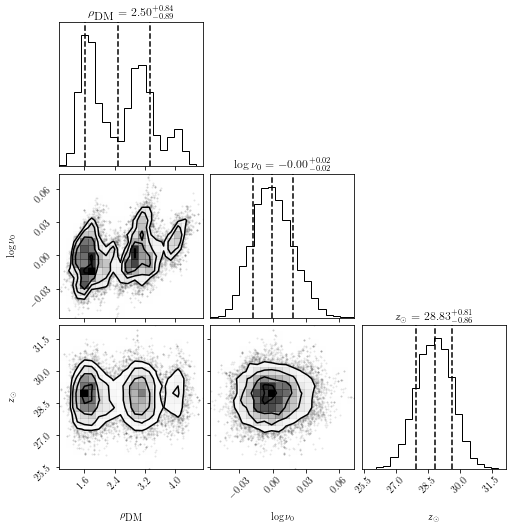

In [24]:
from utils import plot_corner

plot_corner(
    params=params,
    labels=labels,
)

# plot_fit

In [25]:
from tqdm import tqdm
from hammer import Model as MCMC_Model
from scipy.stats import median_abs_deviation as mad
 
class Model(Enum):
    DM = "DM"
    DDDM = "DDDM"
    NO = "NO"
    KIN = "KIN"

func_dict = {
    "DM": MCMC_Model.DM,
    "DDDM": MCMC_Model.DDDM,
    "NO": MCMC_Model.NO,
}


sigma_68 = 0.994458
sigma_90 = 1.644854
sigma_95 = 1.959964

def plot_fit_z(model: Model, flat_chains: np.ndarray, zdata: Tuple[np.ndarray,np.ndarray,np.ndarray], psi: np.ndarray, **options: dict):
    """required: 
            model: `Model` = Model.DM \n
            flat_chain: `ndarray(shape=(n_mcmc, nsample, nparam))`\n
            zdata: `Tuple[np.ndarray,np.ndarray,np.ndarray]` = (zmid, znum, zerr) \n
            psi: `np.ndarray(shape(n_mcmc, 30))` = psi \n
        options:
            res: `int` = 100 \n
            nsample: `int` = 5_000 \n
            figsize: `Tuple[int, int]` = (10, 10) \n
            alpha: `float` = 0.1 \n
            c: `str` = C0 \n
            log: `bool` = False \n
            dpi: `int` = 70 \n
            path: `str` = None \n
            fig_kw: `Dict` = All additional keyword arguments for `.pyplot.figure`.
            """
    res = options.get('res', 100)
    nsample = options.get('nsample', 5_000)
    figsize = options.get('figsize', (10, 6))
    alpha = options.get('alpha', 0.1)
    c = options.get('c', "C0")
    log = options.get('log', False)
    dpi = options.get('dpi', 70)
    path = options.get('path', None)
    fig_kw  = options.get('fig_kw', {})
    func = func_dict.get(model.value, MCMC_Model.DM)
    
    zmid, znum, zerr = zdata
    zs: np.ndarray[np.float64] = np.linspace(zmid.min()*1.1, zmid.max()*1.1, res)
    log_fzs = np.empty((nsample, len(zs)))
    for i in tqdm(range(nsample)):
        psi_ind = np.random.randint(len(flat_chains))
        ind = np.random.randint(flat_chains.shape[1])
        theta = flat_chains[psi_ind, ind]
        ind = np.random.randint(len(psi))
        ps = psi[psi_ind]
        log_fzs[i] = np.log(func.fz(zs, theta, ps))

    fz_log_mean = np.median(log_fzs,axis=0)
    fz_log_std = mad(log_fzs, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=figsize, **fig_kw)
    ax.errorbar(zmid, znum, yerr=zerr, color='k',
                alpha=1, capsize=2, fmt=".")
    ax.plot(zs, np.exp(fz_log_mean), c=c, ls="--")
    for sigma in [sigma_95, sigma_90, sigma_68]:
        ax.fill_between(zs, np.exp(fz_log_mean - sigma*fz_log_std),
                        np.exp(fz_log_mean + sigma*fz_log_std), alpha=alpha, color=c)
    ax.set_ylabel(r'$f_0(z)$')
    ax.set_xlabel(r'$z$ [km/s]')
    ax.set_xlim(zs.min(), zs.max())
    if log:
        ax.set_yscale("log")
        ax.set_ylim(np.exp(fz_log_mean - sigma_95*fz_log_std).min(),
                    np.exp(fz_log_mean + sigma_95*fz_log_std).max()*1.5)
    else:
        ax.set_ylim(0)
    if path is not None:
        fig.savefig(path, dpi=dpi)
    plt.show()

  1%|▏         | 128/10000 [00:00<00:07, 1272.67it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1607.97it/s]


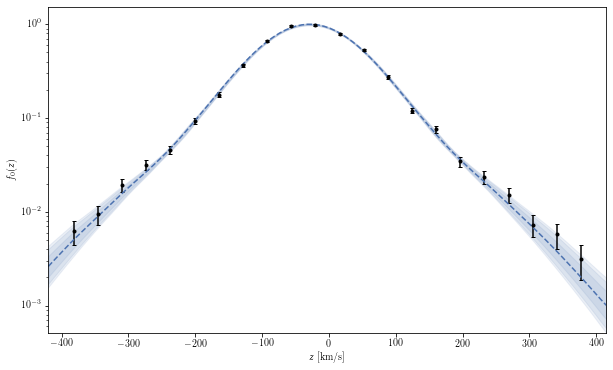

In [26]:
from utils import get_data
zdata = get_data(z_files[index])
flat_chains = chain_thin.reshape(n_mcmc, -1, ndim)
# flat_chains.shape
plot_fit_z(
    model=Model.DM,
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=10_000,
    res=100
)

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:09<00:00, 2088.31it/s]


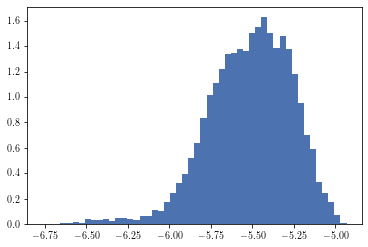

In [20]:
nsample = 20_000
log_fzs = np.empty((nsample))
for i in tqdm(range(nsample)):
    psi_ind = np.random.randint(len(flat_chains))
    ind = np.random.randint(flat_chains.shape[1])
    theta = flat_chains[psi_ind, ind]
    ind = np.random.randint(len(psi))
    ps = psi[psi_ind]
    log_fzs[i] = np.log(Model_MCMC.DM.fz(np.array([300.]), theta, ps))
    
plt.hist(log_fzs, bins=50, density=True);

# calculate max likelihood

In [30]:
from datetime import datetime
from typing import Tuple

def calculate_prob(
        model: Model, 
        flat_chains: np.ndarray, 
        zdata: Tuple[np.ndarray, np.ndarray, np.ndarray], 
        psi: np.ndarray, 
        **options: dict
    ):
    """
    Calculate maximum likelihood, BIC, and AIC, then save the result to a file

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` \n
    flat_chain: ndarray(shape=(n_mcmc, length, ndim)) \n
    zdata: ndarray = (zmid, znum, zerr) \n
    psi: ndarray = (n_mcmc, kin) \n
    options:
        nsample: `int` = 10_000 \n
        verbose: `bool` = True \n
        batch: `int` = 1000 \n
    """
    nsample = options.get("nsample", 10_000)
    verbose = options.get("verbose", True)
    batch = options.get("batch", 1000)
    func = func_dict[model.value]
    if verbose: print("Opening the data")
    init = generate_init(model)
    locs = init['locs']
    scales = init['scales']
    if verbose: print("Opening the chain")
    n_mcmc, length, ndim = flat_chains.shape
    print(flat_chains.shape)
    # flat_chain = chain_thin.reshape(n_mcmc, -1, ndim)
    # calculate likelihood
    if verbose: print("Calculating likelihood")
    probs = func.log_prob_par(flat_chains, psi, zdata, locs, scales, batch=batch)
    mx_l = np.empty(n_mcmc)
    bics = np.empty(n_mcmc)
    aics = np.empty(n_mcmc)
    for i, prob in enumerate(tqdm(probs)):
        likelihood = prob[1]
        # remove nan from likelihood
        likelihood = likelihood[~np.isnan(likelihood)]
        max_likelihood = np.max(likelihood)
        # calculate BIC
        zmid = zdata[0]
        bic = -2 * max_likelihood + ndim * np.log(3*len(zmid))
        aic = -2 * max_likelihood + 2 * ndim
        mx_l[i] = max_likelihood
        bics[i] = bic
        aics[i] = aic
    df = vaex.from_arrays(max_likelihood=mx_l, bic=bics, aic=aics)
    return df

In [32]:
flat_chains.shape

(10, 1500, 3)

In [33]:
# u = np.array([p0[0],p0[0], p0[0], p0[0], p0[0]])
# print(u.shape)

prob_df = calculate_prob(
    model=Model.DM, 
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
)
prob_df.shape

Opening the data
Opening the chain
(10, 1500, 3)
Calculating likelihood


100%|██████████| 10/10 [00:00<00:00, 30615.36it/s]


(10, 3)

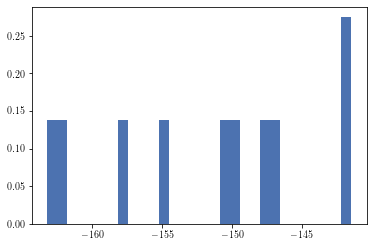

In [34]:
aics = prob_df.aic.to_numpy()
bics = prob_df.bic.to_numpy()
plt.hist(aics, bins=30, density=True);
# plt.hist(bics, bins=30, density=True);

# Script

do mcmc for

* same $N$, different $z$
* same $z$, different $N$

Each 'running' contains
1. generate_init: initial position for walkers.
    * this is done by the experiment above.
2. run_mcmc: run true mcmc for 10_000 steps.
3. plot trace: plot trace plot for preliminary mcmc.
4. plot corner: plot corner plot for the long run.
5. plot fit: fitting plot for vertical density and vertical dispersion.
6. calculate bic & aic: calculate bic and aic for the long run.

All of these functionalities are implemented in `mcmc.py` at `utils`.

Just run the `program.py` at `script`.
To automate the process for all data, run `run_program.py` at `script`.

# test utils

In [1]:
from os.path import abspath, join
from glob import glob
import vaex
from matplotlib import pyplot as plt
import sys
import numpy as np
current = abspath("")
root_dir = abspath(join(current, '..'))
root_data_dir = join(root_dir, "Data")
import sys
if not root_dir in sys.path: 
    sys.path.append(root_dir)

In [2]:
from utils import (style, get_params, mcmc_parallel_z, plot_chain, plot_corner, plot_fit_z, calculate_prob, get_data, Model)

style()

In [3]:
z_dir_path = join(root_data_dir, 'MCMC-no', 'mock', 'data', 'z')
z_dir_path

'/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z'

In [4]:
name = "Baryon"
baryon_dir = join(root_data_dir, name)
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


In [5]:
rhob_mean = df_baryon['rho'].to_numpy()
rhob_err = df_baryon['e_rho'].to_numpy()
sigmaz_mean = df_baryon['sigma_z'].to_numpy()
sigmaz_err = df_baryon['e_sigma_z'].to_numpy()

In [6]:
vel_dir_path = join(root_data_dir, "MCMC-no", "mock", "result", "z", "vel", "data")
vel_files = glob(join(vel_dir_path, "*.npy"))
vel_files.sort()
vel_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.4.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.6.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_0.8.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.0.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_1.5.npy',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/result/z/vel/data/chain_2.0.npy']

In [8]:
index = 4
z_files = glob(join(z_dir_path, "z*"))
z_files.sort()
z_files

['/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.4.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.6.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_0.8.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_1.0.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_1.5.hdf5',
 '/home2/s20321005/Thesis-Project/Data/MCMC-no/mock/data/z/z_2.0.hdf5']

In [9]:
name = z_files[index].split("/")[-1].replace(".hdf5", "").replace("z_", "")
zdata = get_data(z_files[index])
vel = np.load(vel_files[index])
zdata, name, vel[:5]

((array([-474.55985045, -433.28982681, -392.01980317, -350.74977953,
         -309.47975588, -268.20973224, -226.9397086 , -185.66968496,
         -144.39966132, -103.12963767,  -61.85961403,  -20.58959039,
           20.68043325,   61.95045689,  103.22048053,  144.49050418,
          185.76052782,  227.03055146,  268.3005751 ,  309.57059874,
          350.84062239,  392.11064603,  433.38066967,  474.65069331]),
  array([1.83272886e-03, 9.16364431e-04, 8.24727988e-03, 8.24727988e-03,
         1.83272886e-02, 2.19927463e-02, 5.04000437e-02, 1.36538300e-01,
         3.27142102e-01, 5.69978676e-01, 8.88873498e-01, 9.54851737e-01,
         7.70662486e-01, 4.33440376e-01, 2.17178370e-01, 8.24727988e-02,
         4.30691282e-02, 1.83272886e-02, 9.16364431e-03, 1.09963732e-02,
         2.74909329e-03, 2.74909329e-03, 2.74909329e-03, 9.16364431e-04]),
  array([0.00129594, 0.00091636, 0.00274909, 0.00274909, 0.00409811,
         0.00448925, 0.00679594, 0.01118565, 0.0173142 , 0.02285406,
      

#### create baryon realisation

In [11]:
# length = len(vel)
# # baryon_dir
# rhob = np.random.normal(rhob_mean, rhob_err, size=(length, 12))
# sigmaz = np.random.normal(sigmaz_mean, sigmaz_err, size=(length, 12))
# r = np.random.normal(3.4E-3, 0.6E-3, size=(length))

# dyn = np.empty((length, 25))
# dyn[:, :12] = rhob
# dyn[:, 12:24] = sigmaz
# dyn[:, 24] = r

# np.save(join(baryon_dir, "dyn.npy"), dyn)

In [12]:
dyn = np.load(join(baryon_dir, "dyn.npy"))
dyn.shape

(60000, 25)

In [14]:
m = 2000
nsample = vel[::m, 0].shape[0]
print(nsample)
psi = np.empty((nsample, 30))

rhob = dyn[::m, :12]
sigmaz = dyn[::m, 12:24]
r = dyn[::m, 24]
w0 = vel[::m, 0]
log_sigmaw = vel[::m, 1]
q_sigmaw = vel[::m, 2]
log_a = vel[::m, 3]
q_a = vel[::m, 4]

# combine
psi[:, :12] = rhob
psi[:, 12:24] = sigmaz
psi[:, 24] = r
psi[:, 25] = w0
psi[:, 26] = log_sigmaw
psi[:, 27] = q_sigmaw
psi[:, 28] = log_a
psi[:, 29] = q_a

psi.shape

30


(30, 30)

In [15]:
print(mcmc_parallel_z.__doc__)


    Run MCMC

    Parameters
    ----------
    model: `Model` = `Model.DM`, `Model.DDDM`, or `Model.NO` 

    z_path: `str` = path to z file 

    psi: `np.ndarray` = shape(nmcmc, 4) 


    options:
        step0: `int` = 500 

        step: `int` = 2000 

        burn: `int` = 1000 

        it: `int` = 3 

        thin: `int` = 20 

        verbose: `bool` = True 

        m: `int` = 10 (multiplier, `nwalker = m*ndim`)
        
    Returns
    -------
    result: `dict` = { 

        indexes: `ndarray(shape(nparam))`, 

        labs: `ndarray(shape(nparam))`, 

        labels: `ndarray(shape(nparam))`, 

        chain: `ndarray(shape(nstep,nwalker,nparam))` 

    }
    


# DM

In [16]:
result = mcmc_parallel_z(
    model=Model.DM,
    z_path=z_files[index],
    psi=psi,
    step0=50,
    step=100,
    burn=100,
    it=1,
    thin=2,
    m=10
)
# result.shape
result.keys()

running...
mcmc... 1.5
(30, 30, 3)


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 3.69 s


mcmc: 100%|██████████| 1/1 [00:07<00:00,  7.33s/it]

0: second half mcmc done 3.61 s
burn done 7.06 s
mcmc done 7.05 s

dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [17]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
n_mcmc, step, nwalker, ndim = chain_thin.shape
n_mcmc, step, nwalker, ndim

(30, 50, 30, 3)

100%|██████████| 3/3 [00:01<00:00,  2.78it/s]


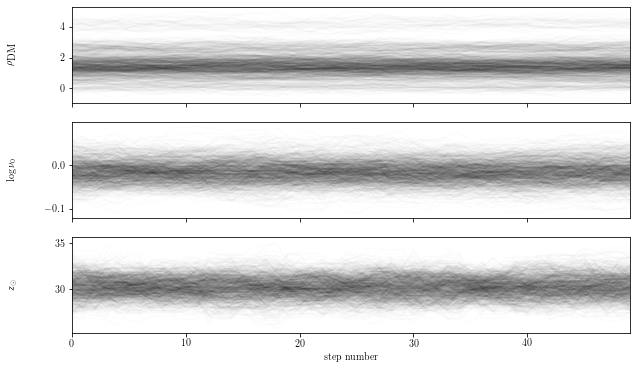

In [19]:
chain = np.transpose(chain_thin, (1, 0, 2, 3)).reshape((step, -1, ndim))
params = get_params(chain, indexes, labs)

plot_chain(
    params=params[:, :],
    labels=labels,
    alpha=0.01,
    figsize=(10, 6),
)

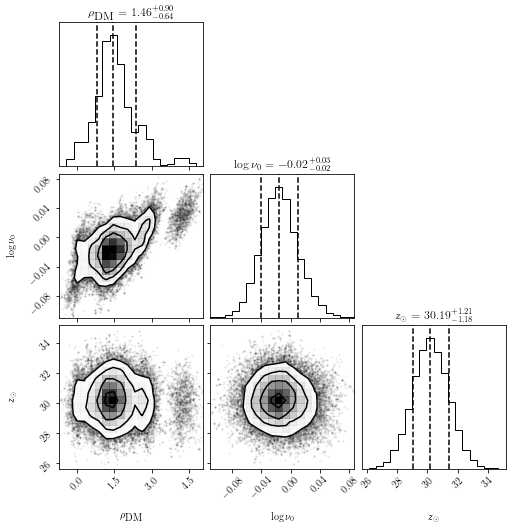

In [20]:
plot_corner(
    params=params,
    labels=labels,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1519.73it/s]


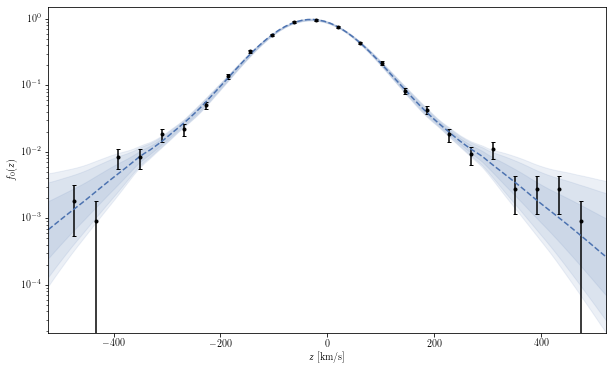

In [21]:
zdata = get_data(z_files[index])
flat_chains = chain_thin.reshape(n_mcmc, -1, ndim)
# flat_chains.shape
plot_fit_z(
    model=Model.DM,
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=10_000,
    res=100
)

In [22]:
prob_df = calculate_prob(
    model=Model.DM, 
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
)
prob_df

Opening the data
Opening the chain
(30, 1500, 3)
Calculating likelihood


100%|██████████| 30/30 [00:00<00:00, 59297.42it/s]


#,max_likelihood,bic,aic
0,90.23060266018797,-167.63120696332777,-174.46120532037594
1,50.55376184255318,-88.27752532805819,-95.10752368510636
2,91.41001692662599,-169.9900354962038,-176.82003385325197
3,93.2420958118455,-173.65419326664284,-180.484191623691
4,94.14762473179275,-175.46525110653732,-182.2952494635855
...,...,...,...
25,90.32226811044788,-167.8145378638476,-174.64453622089576
26,87.84137073220259,-162.852743107357,-169.68274146440518
27,88.69177977267483,-164.5535611883015,-171.38355954534967
28,73.6983558276115,-134.56671329817482,-141.396711655223


-182.2952494635855


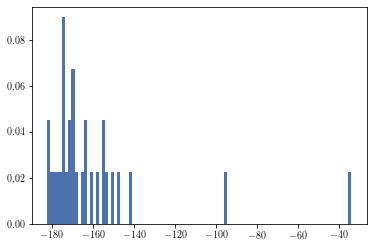

In [23]:
aics = prob_df.aic.to_numpy()
bics = prob_df.bic.to_numpy()
plt.hist(aics, bins=100, density=True);
print(aics.min())

## DDDM

In [24]:
result = mcmc_parallel_z(
    model=Model.DDDM,
    z_path=z_files[index],
    psi=psi,
    step0=50,
    step=100,
    burn=100,
    it=1,
    thin=2,
    m=10
)
# result.shape
result.keys()

running...
mcmc... 1.5
(30, 50, 5)


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 6.51 s


mcmc: 100%|██████████| 1/1 [00:13<00:00, 13.55s/it]

0: second half mcmc done 7.0 s


burn done 12.24 s
mcmc done 11.82 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [25]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
n_mcmc, step, nwalker, ndim = chain_thin.shape
n_mcmc, step, nwalker, ndim

(30, 50, 50, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:02<00:00,  1.81it/s]


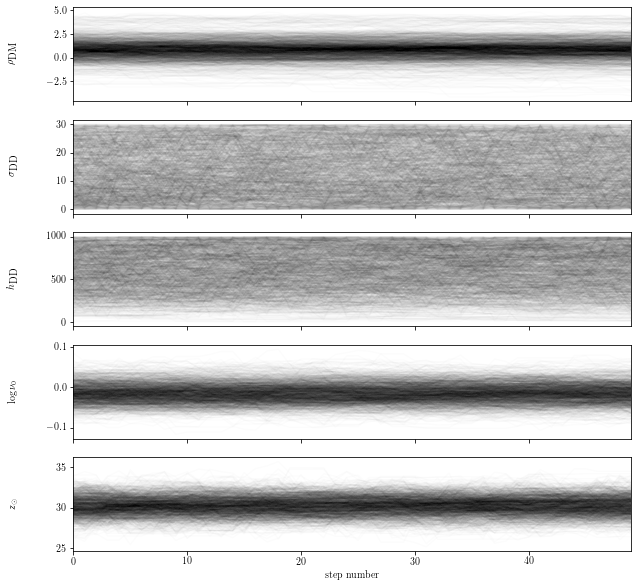

In [26]:
chain = np.transpose(chain_thin, (1, 0, 2, 3)).reshape((step, -1, ndim))
params = get_params(chain, indexes, labs)

plot_chain(
    params=params[:, :],
    labels=labels,
    alpha=0.01,
    figsize=(10, 10),
)

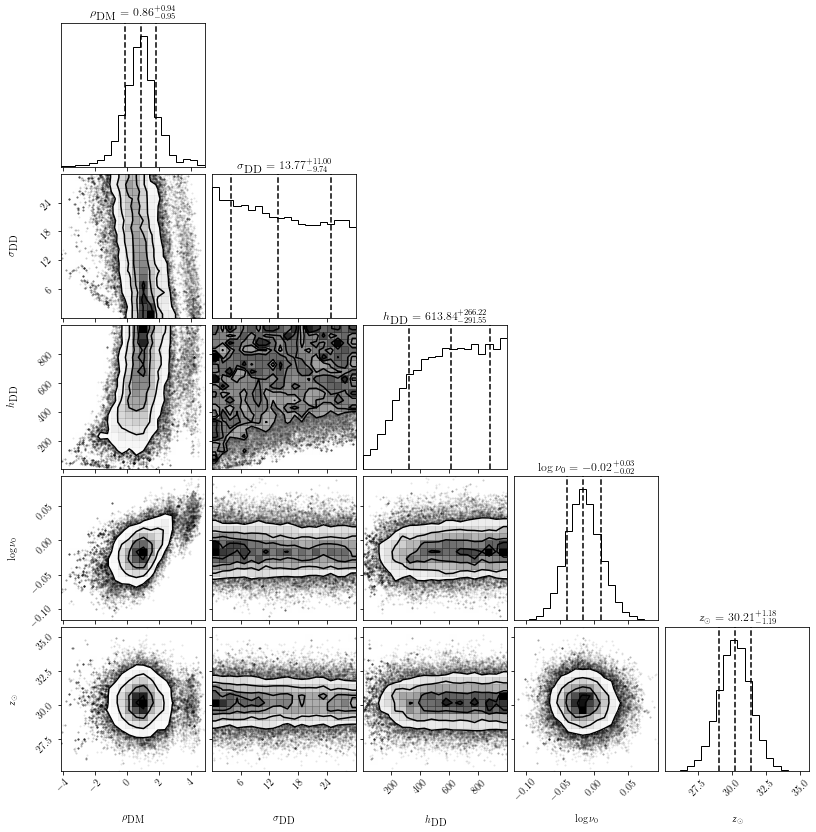

In [27]:
plot_corner(
    params=params,
    labels=labels,
)

  1%|          | 117/10000 [00:00<00:08, 1162.64it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1491.40it/s]


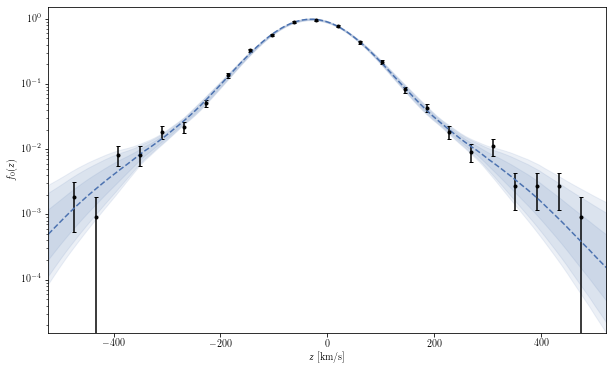

In [28]:
zdata = get_data(z_files[index])
flat_chains = chain_thin.reshape(n_mcmc, -1, ndim)
# flat_chains.shape
plot_fit_z(
    model=Model.DDDM,
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=10_000,
    res=100
)

In [29]:
prob_df = calculate_prob(
    model=Model.DDDM, 
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi
)
prob_df

Opening the data
Opening the chain
(30, 2500, 5)
Calculating likelihood


100%|██████████| 30/30 [00:00<00:00, 56173.71it/s]


#,max_likelihood,bic,aic
0,90.38442052357951,-159.38551045207873,-170.76884104715901
1,51.4803111425949,-81.57729169010952,-92.9606222851898
2,91.9770643375661,-162.57079808005193,-173.9541286751322
3,92.8190606428397,-164.25479069059912,-175.6381212856794
4,88.56121278928023,-155.7390949834802,-167.12242557856047
...,...,...,...
25,91.33285518397412,-161.28237977286796,-172.66571036794824
26,86.88873830318659,-152.3941460112929,-163.77747660637317
27,92.05935767637914,-162.735384757678,-174.11871535275827
28,75.21604276028536,-129.04875492549044,-140.43208552057072


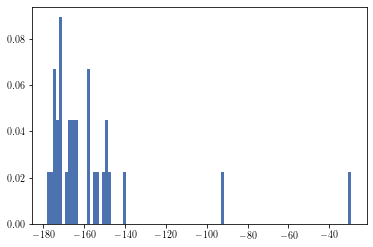

In [30]:
aics = prob_df.aic.to_numpy()
bics = prob_df.bic.to_numpy()
plt.hist(aics, bins=100, density=True);
# plt.hist(bics, bins=30, density=True);

# NO

In [31]:
result = mcmc_parallel_z(
    model=Model.NO,
    z_path=z_files[index],
    psi=psi,
    step0=50,
    step=100,
    burn=100,
    it=1,
    thin=2,
    m=10
)
# result.shape
result.keys()

running...
mcmc... 1.5
(30, 30, 3)


mcmc:   0%|          | 0/1 [00:00<?, ?it/s]

0: first half mcmc done 4.02 s


mcmc: 100%|██████████| 1/1 [00:08<00:00,  8.20s/it]

0: second half mcmc done 4.16 s
burn done 7.48 s
mcmc done 6.95 s


dict_keys(['indexes', 'labs', 'labels', 'chain'])

In [32]:
chain_thin = result['chain']
indexes = result['indexes']
labs = result['labs']
labels = result['labels']
n_mcmc, step, nwalker, ndim = chain_thin.shape
n_mcmc, step, nwalker, ndim

(30, 50, 30, 3)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:01<00:00,  2.33it/s]


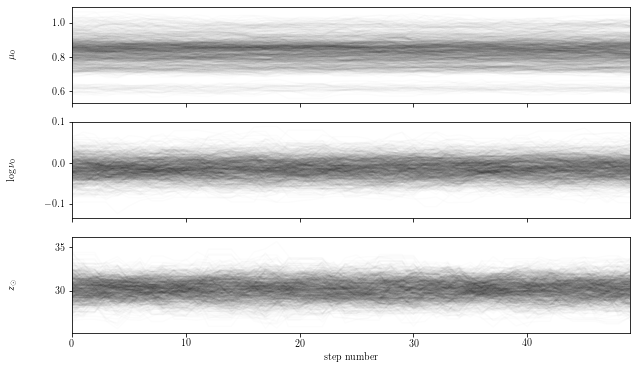

In [33]:
chain = np.transpose(chain_thin, (1, 0, 2, 3)).reshape((step, -1, ndim))
params = get_params(chain, indexes, labs)

plot_chain(
    params=params[:, :],
    labels=labels,
    alpha=0.01,
    figsize=(10, 6),
)

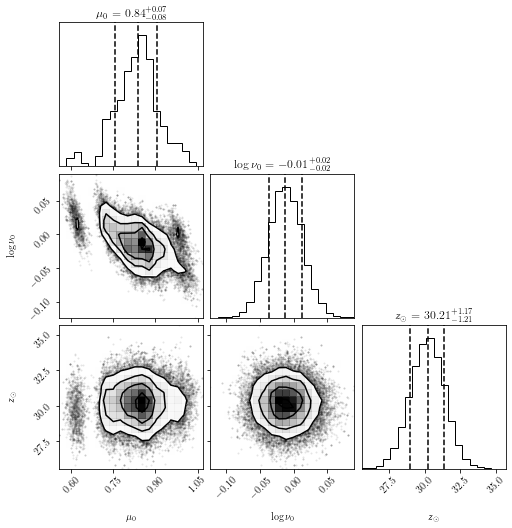

In [34]:
plot_corner(
    params=params,
    labels=labels,
)

In [45]:
len(range(0, 60_000, 60))

1000

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:06<00:00, 1560.12it/s]


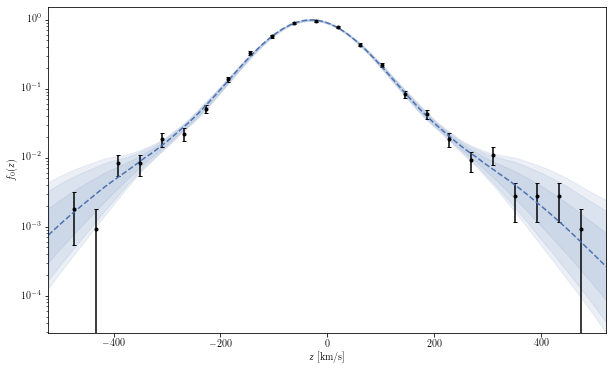

In [35]:
zdata = get_data(z_files[index])
flat_chains = chain_thin.reshape(n_mcmc, -1, ndim)
# flat_chains.shape
plot_fit_z(
    model=Model.NO,
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi,
    log=True,
    nsample=10_000,
    res=100
)

In [36]:
prob_df = calculate_prob(
    model=Model.NO, 
    flat_chains=flat_chains,
    zdata=zdata,
    psi=psi
)
prob_df

Opening the data
Opening the chain
(30, 1500, 3)
Calculating likelihood


100%|██████████| 30/30 [00:00<00:00, 57482.47it/s]


#,max_likelihood,bic,aic
0,84.8421854713615,-156.85437258567484,-163.684370942723
1,24.683248889585535,-36.5364994221229,-43.36649777917107
2,88.16220994956274,-163.4944215420773,-170.32441989912547
3,89.67319414943518,-166.51638994182218,-173.34638829887035
4,94.99856490547054,-177.16713145389292,-183.9971298109411
...,...,...,...
25,90.23663379277261,-167.64326922849705,-174.47326758554522
26,86.44758114248054,-160.06516392791292,-166.8951622849611
27,91.85550230064933,-170.8810062442505,-177.71100460129867
28,73.0717071137191,-133.31341587039003,-140.1434142274382


In [41]:
len(range(0, 60_000, 2000))

30

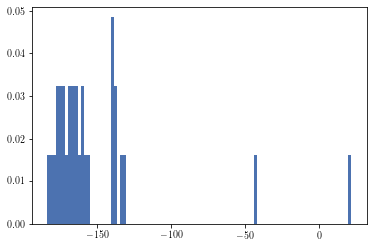

In [37]:
aics = prob_df.aic.to_numpy()
bics = prob_df.bic.to_numpy()
plt.hist(aics, bins=100, density=True);
# plt.hist(bics, bins=30, density=True);

In [38]:
aics.min()

-183.9971298109411